In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import scipy
import math
import copy
import noise

In [66]:
# helper functions
def find_neighbours(arr):

    neighbors = []

    for i in range(len(arr)):
        for j, value in enumerate(arr[i]):

            if i == 0 or i == len(arr) - 1 or j == 0 or j == len(arr[i]) - 1:
                # corners
                new_neighbors = []
                if i != 0:
                    new_neighbors.append(arr[i - 1][j])  # top neighbor
                if j != len(arr[i]) - 1:
                    new_neighbors.append(arr[i][j + 1])  # right neighbor
                if i != len(arr) - 1:
                    new_neighbors.append(arr[i + 1][j])  # bottom neighbor
                if j != 0:
                    new_neighbors.append(arr[i][j - 1])  # left neighbor

            else:
                # add neighbors
                new_neighbors = [
                    arr[i - 1][j],  # top neighbor
                    arr[i][j + 1],  # right neighbor
                    arr[i + 1][j],  # bottom neighbor
                    arr[i][j - 1]   # left neighbor
                ]

            neighbors.append({
                value: new_neighbors
                })

    return neighbors


def neighbors_full(matrix,radius, row_number, column_number):
     return [[matrix[i][j] if  i >= 0 and i < len(matrix) and j >= 0 and j < len(matrix[0]) else 0
                for j in range(column_number-1-radius, column_number+radius)]
                    for i in range(row_number-1-radius, row_number+radius)]


def flatten(l):
    return [item for sublist in l for item in sublist]

def sigmoid(x):
            return 1.0 / (1.0 + np.exp(-0.5*x))

def calculate_next_step(pheromones_l,pheromones_r):
    p_left = ((5+pheromones_l)**2)/((5+pheromones_l)**2+((5+pheromones_r)**2))
    p_right = 1 - p_left

    return p_left, p_right

def take_next_step(pheromones_l,pheromones_r):
    return 0.5 + 0.5*np.tanh((pheromones_l+pheromones_r)/100 -1)


def multiplot(nodes,two=False):
    food_dist = []
    pheromone_dist = []
    max_capa_dist = []
    capacity_dist = []


    for i in range(len(nodes)):
        food_dist.append(nodes[i].get_food())
        capacity_dist.append(nodes[i].get_capacity())
        max_capa_dist.append(nodes[i].get_max_capacity())
        pheromone_dist.append(nodes[i].get_pheromones())


    food_dist = np.array(food_dist).reshape(-1,int(np.sqrt(len(nodes))))
    capacity_dist = np.array(capacity_dist).reshape(-1,int(np.sqrt(len(nodes))))
    max_capa_dist = np.array(max_capa_dist).reshape(-1,int(np.sqrt(len(nodes))))
    pheromone_dist = np.array(pheromone_dist).reshape(-1,int(np.sqrt(len(nodes))))

    
    if two == True:
        fig, axes = plt.subplots(1, 2,figsize=(20,8),dpi=100)
        sns.heatmap(capacity_dist,ax=axes[0],cmap="viridis",annot=False,vmax=1,xticklabels=False,yticklabels=False)
        axes[0].set_title('Capacity')
        axes[0].set_xlabel('X-Axis', fontsize=10)
        axes[0].set_ylabel('Y-Axis', fontsize=10)
        sns.heatmap(pheromone_dist,ax=axes[1],cmap="viridis",annot=False,vmax=100,xticklabels=False,yticklabels=False)
        axes[1].set_title('Pheromones')
        axes[1].set_xlabel('X-Axis', fontsize=10)
        axes[1].set_ylabel('Y-Axis', fontsize=10)

    else:
        fig, axes = plt.subplots(2, 2,figsize=(20,16),dpi=100)
        sns.heatmap(capacity_dist,ax=axes[0,0],cmap="viridis",annot=False,vmax=1,xticklabels=False,yticklabels=False)
        axes[0,0].set_title('Capacity')
        axes[0,0].set_xlabel('X-Axis', fontsize=10)
        axes[0,0].set_ylabel('Y-Axis', fontsize=10)
        sns.heatmap(pheromone_dist,ax=axes[0,1],cmap="viridis",annot=False,vmax=200,xticklabels=False,yticklabels=False)
        axes[0,1].set_title('Pheromones')
        axes[0,1].set_xlabel('X-Axis', fontsize=10)
        axes[0,1].set_ylabel('Y-Axis', fontsize=10)
        sns.heatmap(max_capa_dist,ax=axes[1,0],cmap="terrain",annot=False,vmax=20,xticklabels=False,yticklabels=False)
        axes[1,0].set_title('maximum capacity')
        axes[1,0].set_xlabel('X-Axis', fontsize=10)
        axes[1,0].set_ylabel('Y-Axis', fontsize=10)
        sns.heatmap(food_dist,ax=axes[1,1],cmap="viridis",annot=False,vmax=400,xticklabels=False,yticklabels=False)
        axes[1,1].set_title('Food')
        axes[1,1].set_xlabel('X-Axis', fontsize=10)
        axes[1,1].set_ylabel('Y-Axis', fontsize=10)



In [67]:
# nodes class and ant class
class CreateNodes:
    def __init__(self, food=0, pheromones=0,x_coord=0, y_coord=0,evaporation_rate=1):
        self._food = food
        self._pheromones = pheromones
        self._max_pheromones = 100
        self._evaporation_rate = evaporation_rate
        self._capacity = 0
        self._max_capacity = 20
        self._x_coordinates = x_coord
        self._y_coordinates = y_coord
        self._connected_nodes = None
        self._connected_nodes_backwards = None
        self._connected_nodes_forwards = None
        self._node_number = None

    def create_label(self,label):
        self._node_number = label

    def update_food(self, food):
        self._food = food 
        
    def increase_food(self):
        self._food += 1

    def decrease_food(self):
        self._food -= 1

    def update_pheromones(self, dropped_pheromones):
        self._pheromones = self._pheromones + dropped_pheromones

    def reset_pheromones(self):
        self._pheromones = 0

    def set_pheromones(self,pheromones):
        self._pheromones = pheromones

    def evaporation(self):
        self._pheromones = self._pheromones - self._pheromones * self._evaporation_rate

    def set_capacity(self):
        self._capacity = 10

    def update_capacity(self, new_capacity):
        self._capacity = self._capacity + new_capacity

    def increase_capacity(self):
        self._capacity = self._capacity + 1

    def reduce_capacity(self):
        self._capacity = self._capacity - 1

    def update_max_capacity(self, max_capacity):
        self._max_capacity = max_capacity

    def update_x_coordinates(self, x_coord):
        self._x_coordinates = x_coord

    def update_y_coordinates(self, y_coord):
        self._y_coordinates = y_coord

    def update_connected_nodes(self, connected_nodes):
        self._connected_nodes = connected_nodes

    def update_connected_nodes_backwards(self):
        self._connected_nodes_backwards = [node for node in self._connected_nodes if node < self._node_number]

    def update_connected_nodes_forwards(self):
        self._connected_nodes_forwards = [node for node in self._connected_nodes if node > self._node_number]

    def get_label(self):
        return self._node_number

    def get_food(self):
        return self._food

    def get_pheromones(self):
        return self._pheromones

    def get_capacity(self):
        return self._capacity

    def get_x_coordinates(self):
        return self._x_coordinates

    def get_y_coordinates(self):
        return self._y_coordinates

    def get_node_number(self):
        return self._node_number

    def get_connected_nodes(self):
        return self._connected_nodes

    def get_connected_nodes_backwards(self):
        return self._connected_nodes_backwards
    
    def get_connected_nodes_forwards(self):
        return self._connected_nodes_forwards

    def get_max_capacity(self):
        return self._max_capacity

class Ants:
    def __init__(self):
        self._food = 0
        self._location = None
        self._ant_number = None

    def food_level(self):
        return self._food

    def pick_up_food(self, food):
        self._food = food
    
    def drop_food(self):
        self._food = 0
        
    def update_ant_number(self, ant_number):
        self._ant_number = ant_number

    def get_ant_number(self):
        return self._ant_number

    def update_location(self,location):
        self._location = location
    
    def get_location(self):
        return self._location

In [68]:
# create nodes for the experiment
def create_nodes(n,evaporation_rate,experiment=1,randomise_capacity=False,terrain=False,one_tree = False,realistic_world=True):
    nodes = {}

    # experiment 1
    if experiment == 1:
        population = [0,0] # w/ 0,0 there is no food
        weights = [0.5,0.5]

    elif experiment == 2:
        # experiment 2
        population = [0,1] # w/ 0,0 there is no food
        weights = [0.5,0.5]

    elif experiment == 3:
            # experiment 3
        population = [0,400] # w/ 0,0 there is no food
        weights = [48/50,1/50]

    elif experiment == 4:
        population = [0,1,2,10] # w/ 0,0 there is no food
        weights = [0.5,0.3,0.1,0.01]

    ys = []

    for i in range(0,int(math.sqrt(n))):
        for j in range(0,int(math.sqrt(n))):
            ys.append(j)

    ys = sorted(ys)

    
    nodes = {}
    node_labels = list(range(n))

    for i in range(n):
        food = random.choices(population, weights=weights)[0]
        nodes[i] = CreateNodes(food=food,x_coord=i,evaporation_rate=evaporation_rate)
        nodes[i].create_label(i)

    for idx, j in enumerate(ys):
        nodes[node_labels[idx]].update_y_coordinates(j)

    node_array = np.array(node_labels).reshape(-1,int(math.sqrt(n)))
    neigbors_dict = find_neighbours(node_array)

    for i in range(n):
        nodes[i].update_connected_nodes(neigbors_dict[i][i])
        nodes[i].update_connected_nodes_backwards()
        nodes[i].update_connected_nodes_forwards()


    if randomise_capacity:
        for i in range(n):
            nodes[i].update_max_capacity(random.randint(5,20))

    if realistic_world:
        shape = (int(np.sqrt(n)),int(np.sqrt(n)))
        scale = 300.0
        octaves = 60
        persistence = 0.6
        lacunarity = 2

        world = np.zeros(shape)
        for i in range(shape[0]):
            for j in range(shape[1]):
                world[i][j] = noise.pnoise2(i/scale, 
                                            j/scale, 
                                            octaves=octaves, 
                                            persistence=persistence, 
                                            lacunarity=lacunarity, 
                                            repeatx=1024, 
                                            repeaty=1024, 
                                            base=50) # 42 good, 12 linear, # 33 good

        world = np.around(np.interp(world, (world.min(), world.max()), (0,51)),0)
        
        for i in range(len(world)):
            for j in range(len(world)):
                if world[i][j] > 20:
                    world[i][j] = world[i][j] - world[i][j] * sigmoid(world[i][j]- 20)
                else:
                    world[i][j] = world[i][j]

        
        counter = 0
        for i in range(shape[0]):
            for j in range(shape[0]):
                nodes[counter].update_max_capacity(world[i,j])
                counter += 1

    if terrain:
        A = np.arange(n).reshape(-1,int(np.sqrt(n)))
        all_nodes = A.flatten().tolist()

    
        for i in range(10):
            tree = random.choice(all_nodes)
            tree_index = np.where(A==tree)
            tree_values = flatten(neighbors_full(A,random.randint(3,4),int(tree_index[0]),int(tree_index[1])))

            for node in range(len(nodes)):
                if nodes[node].get_node_number() in tree_values:
                    nodes[node].set_pheromones(-np.inf)
                    nodes[node].update_max_capacity(-np.inf)
                    nodes[node].update_capacity(-np.inf)

    if one_tree:
        A = np.arange(n).reshape(-1,int(np.sqrt(n)))
        tree = A[20,35]
        tree2 = A[35,75]

        tree_list = [tree, tree2]
        tree_nodes = []

        
        for tree in tree_list:
            tree_index = np.where(A==tree)
            tree_nodes.append(flatten(neighbors_full(A,random.randint(3,4),int(tree_index[0]),int(tree_index[1]))))

        tree_nodes = flatten(tree_nodes)

        for node in range(len(nodes)):
                if nodes[node].get_node_number() in tree_nodes:
                    nodes[node].update_max_capacity(-np.inf)
                    nodes[node].update_capacity(-np.inf)
                    nodes[node].update_food(-10)
                    nodes[node].set_pheromones(-np.inf)

    return nodes, node_array

In [80]:
def model(nodes,steps,ants_per_step,max_ants):
    ants = []
    no_ants = len(ants)

    A = np.arange(len(nodes)).reshape(int(np.sqrt(len(nodes))),-1)
    start_node =  A[5,5] # this has to be automated
    nest_nodes = A[0:10,0:10].flatten().tolist()
    no_food_zone = A[0:20,0:20].flatten().tolist()

    for i in no_food_zone:
        nodes[i].update_food(0)
        nodes[i].update_max_capacity(20)

    nodes[start_node].update_max_capacity(10000)
    counter = 0

    for step in range(steps):
        for node in nodes: # evaporates some of the pheromones each step
            nodes[node].evaporation()
            pass
            

        if len(ants) < max_ants: # adding new ants until limit is reached at every step
            for i in range(ants_per_step): 
                test_ant = Ants()
                test_ant.update_ant_number(counter)
                test_ant.update_location(start_node)
                ants.append(test_ant)
                nodes[start_node].increase_capacity()
                counter += 1


        for i in range(len(ants)):
            location = ants[i].get_location()
        
            # has no food
            if ants[i].food_level() == 0:
                next_nodes = nodes[location].get_connected_nodes_forwards()

                pheromones_l = nodes[next_nodes[0]].get_pheromones()
                try:
                    pheromones_r = nodes[next_nodes[1]].get_pheromones()
                except:
                    ants[i].drop_food()
                    current_location = ants[i].get_location()
                    nodes[current_location].update_capacity(0)
                    ants[i].update_location(start_node)

                    continue
                
                probability_l, probability_r = calculate_next_step(pheromones_l,pheromones_r)

                # if step < 10:
                #     next_step_prob = 1
                # else:
                
                next_step_prob = take_next_step(pheromones_l,pheromones_r)



                if random.random() < next_step_prob:
                    if random.random() <= probability_l:
                        if nodes[next_nodes[0]].get_capacity() < nodes[next_nodes[0]].get_max_capacity():
                            
                            nodes[location].reduce_capacity()
                            ants[i].update_location(next_nodes[0]) # update ants location

                            if nodes[next_nodes[0]].get_pheromones() >= 1000:
                                pass
                            else:
                                nodes[next_nodes[0]].update_pheromones(2) # update next nodes pheromoes

                            nodes[next_nodes[0]].update_capacity(1) # update next nodes capacity
                            if nodes[next_nodes[0]].get_food() != 0:
                                ants[i].pick_up_food(1) # pick up food 
                                nodes[next_nodes[0]].decrease_food() # remove food from next node



                        elif nodes[next_nodes[1]].get_capacity() < nodes[next_nodes[1]].get_max_capacity():
                            
                            nodes[location].reduce_capacity()
                            ants[i].update_location(next_nodes[1]) # update ants location
                            
                            if nodes[next_nodes[1]].get_pheromones() >= 1000: # update pheromones
                                pass
                            else:
                                nodes[next_nodes[1]].update_pheromones(2)

                            nodes[next_nodes[1]].update_capacity(1)

                            if nodes[next_nodes[1]].get_food()!= 0:
                                ants[i].pick_up_food(1)
                                nodes[next_nodes[1]].decrease_food()


                        else:
                            continue


                    elif random.random() > probability_l:
                        if nodes[next_nodes[1]].get_capacity() < nodes[next_nodes[1]].get_max_capacity():

                            nodes[location].reduce_capacity()
                            ants[i].update_location(next_nodes[1])

                            if nodes[next_nodes[1]].get_pheromones() >= 1000:
                                pass
                            else:
                                nodes[next_nodes[1]].update_pheromones(2)

                            nodes[next_nodes[1]].update_capacity(1)
                        
                            if nodes[next_nodes[1]].get_food()!= 0:
                                ants[i].pick_up_food(1)
                                nodes[next_nodes[1]].decrease_food()





                        elif nodes[next_nodes[0]].get_capacity() < nodes[next_nodes[0]].get_max_capacity():
                            
                            nodes[location].reduce_capacity()
                            ants[i].update_location(next_nodes[0]) # update ants location

                            if nodes[next_nodes[0]].get_pheromones() >= 1000:
                                pass
                            else:
                                nodes[next_nodes[0]].update_pheromones(2) # update next nodes pheromoes

                            nodes[next_nodes[0]].update_capacity(1) # update next nodes capacity
                            if nodes[next_nodes[0]].get_food() != 0:
                                ants[i].pick_up_food(1) # pick up food 
                                nodes[next_nodes[0]].decrease_food()


                    else:
                        continue

                else:
                    continue


            # ant has food 
            elif ants[i].food_level() == 1:
                next_nodes = nodes[location].get_connected_nodes_backwards()
                
                pheromones_l = nodes[next_nodes[0]].get_pheromones()
                try:
                    pheromones_r = nodes[next_nodes[1]].get_pheromones()
                except:
                    ants[i].drop_food()
                    current_location = ants[i].get_location()
                    nodes[current_location].update_capacity(0)
                    ants[i].update_location(start_node)
                    continue

                

                probability_l, probability_r = calculate_next_step(pheromones_l,pheromones_r)

                if probability_l == probability_r:
                    # print(ants[i].get_ant_number(), 'WARNING! STRAY ANT')
                    ants[i].drop_food()
                    current_location = ants[i].get_location()
                    # nodes[current_location].update_capacity(0)
                    nodes[current_location].reset_pheromones()
                    ants[i].update_location(start_node)

                if ants[i].get_location() < start_node:
                    ants[i].drop_food()
                    current_location = ants[i].get_location()
                    # nodes[current_location].update_capacity(0)
                    # nodes[current_location].reset_pheromones()
                    ants[i].update_location(start_node)



                next_step_prob = take_next_step(pheromones_l,pheromones_r)

                if random.random() < next_step_prob:
                    if random.random() <= probability_l:
                        if nodes[next_nodes[0]].get_capacity() < nodes[next_nodes[0]].get_max_capacity():
                            
                            nodes[location].reduce_capacity()
                            ants[i].update_location(next_nodes[0]) # update ants location

                            if next_nodes[0] in nest_nodes:
                                ants[i].drop_food()
                                nodes[start_node].increase_food()


                            if nodes[next_nodes[0]].get_pheromones() >= 300:
                                pass
                            else:
                                nodes[next_nodes[0]].update_pheromones(10) # update next nodes pheromoes
                            nodes[next_nodes[0]].update_capacity(1) # update next nodes capacity


                        elif nodes[next_nodes[1]].get_capacity() < nodes[next_nodes[1]].get_max_capacity():
                            
                            nodes[location].reduce_capacity()
                            ants[i].update_location(next_nodes[1]) # update ants location


                            if next_nodes[1] in nest_nodes:
                                ants[i].drop_food()
                                nodes[start_node].increase_food()
                            
                            if nodes[next_nodes[1]].get_pheromones() >= 300: # update pheromones
                                pass
                            else:
                                nodes[next_nodes[1]].update_pheromones(10)

                            nodes[next_nodes[1]].update_capacity(1)

                        else:
                            continue


                    elif random.random() > probability_l:
                        if nodes[next_nodes[1]].get_capacity() < nodes[next_nodes[1]].get_max_capacity():

                            nodes[location].reduce_capacity()
                            ants[i].update_location(next_nodes[1])

                            if next_nodes[1] in nest_nodes:
                                ants[i].drop_food()
                                nodes[start_node].increase_food()

                            if nodes[next_nodes[1]].get_pheromones() >= 300:
                                pass
                            else:
                                nodes[next_nodes[1]].update_pheromones(10)

                            nodes[next_nodes[1]].update_capacity(1)
                        

                        elif nodes[next_nodes[0]].get_capacity() < nodes[next_nodes[0]].get_max_capacity():
                            
                            nodes[location].reduce_capacity()
                            ants[i].update_location(next_nodes[0]) # update ants location

                            if next_nodes[0] in nest_nodes:
                                ants[i].drop_food()
                                nodes[start_node].increase_food()

                            if nodes[next_nodes[0]].get_pheromones() >= 300:
                                pass
                            else:
                                nodes[next_nodes[0]].update_pheromones(10) # update next nodes pheromoes

                            nodes[next_nodes[0]].update_capacity(1) # update next nodes capacity


                        else:
                            continue
                        
                    else:
                        continue

                else:
                    continue






            else:
                continue


    nodes[start_node].set_capacity()

    # Analytics
    returning_ants = 0
    exploring_ants = 0

    for i in range(len(ants)):
        if ants[i].food_level() == 1:
            returning_ants += 1
        elif  ants[i].food_level() == 0:
            exploring_ants += 1
       
    print(f'Currently {exploring_ants} ants are searching for food and {returning_ants} ants transport food back to the nest. {nodes[start_node].get_food()} food items are in the nest.')


    for i in range(len(nest_nodes)):
        print(i)
        print(nodes[i].get_pheromones())

                





    return nodes

Currently 1779 ants are searching for food and 721 ants transport food back to the nest. 1929 food items are in the nest.
0
0.0
1
0.0
2
0.0
3
0.0
4
0.0
5
0.0
6
0.0
7
0.0
8
0.0
9
0.0
10
0.0
11
0.0
12
0.0
13
0.0
14
0.0
15
0.0
16
0.0
17
0.0
18
0.0
19
0.0
20
0.0
21
0.0
22
0.0
23
0.0
24
0.0
25
0.0
26
0.0
27
0.0
28
0.0
29
0.0
30
0.0
31
0.0
32
0.0
33
0.0
34
0.0
35
0.0
36
0.0
37
0.0
38
0.0
39
0.0
40
0.0
41
0.0
42
0.0
43
0.0
44
0.0
45
0.0
46
0.0
47
0.0
48
0.0
49
0.0
50
0.0
51
0.0
52
0.0
53
0.0
54
0.0
55
0.0
56
0.0
57
0.0
58
0.0
59
0.0
60
0.0
61
0.0
62
0.0
63
0.0
64
0.0
65
0.0
66
0.0
67
0.0
68
0.0
69
0.0
70
0.0
71
0.0
72
0.0
73
0.0
74
0.0
75
0.0
76
0.0
77
0.0
78
0.0
79
0.0
80
0.0
81
0.0
82
0.0
83
0.0
84
0.0
85
0.0
86
0.0
87
0.0
88
0.0
89
0.0
90
0.0
91
0.0
92
0.0
93
0.0
94
0.0
95
0.0
96
0.0
97
0.0
98
0.0
99
0.0


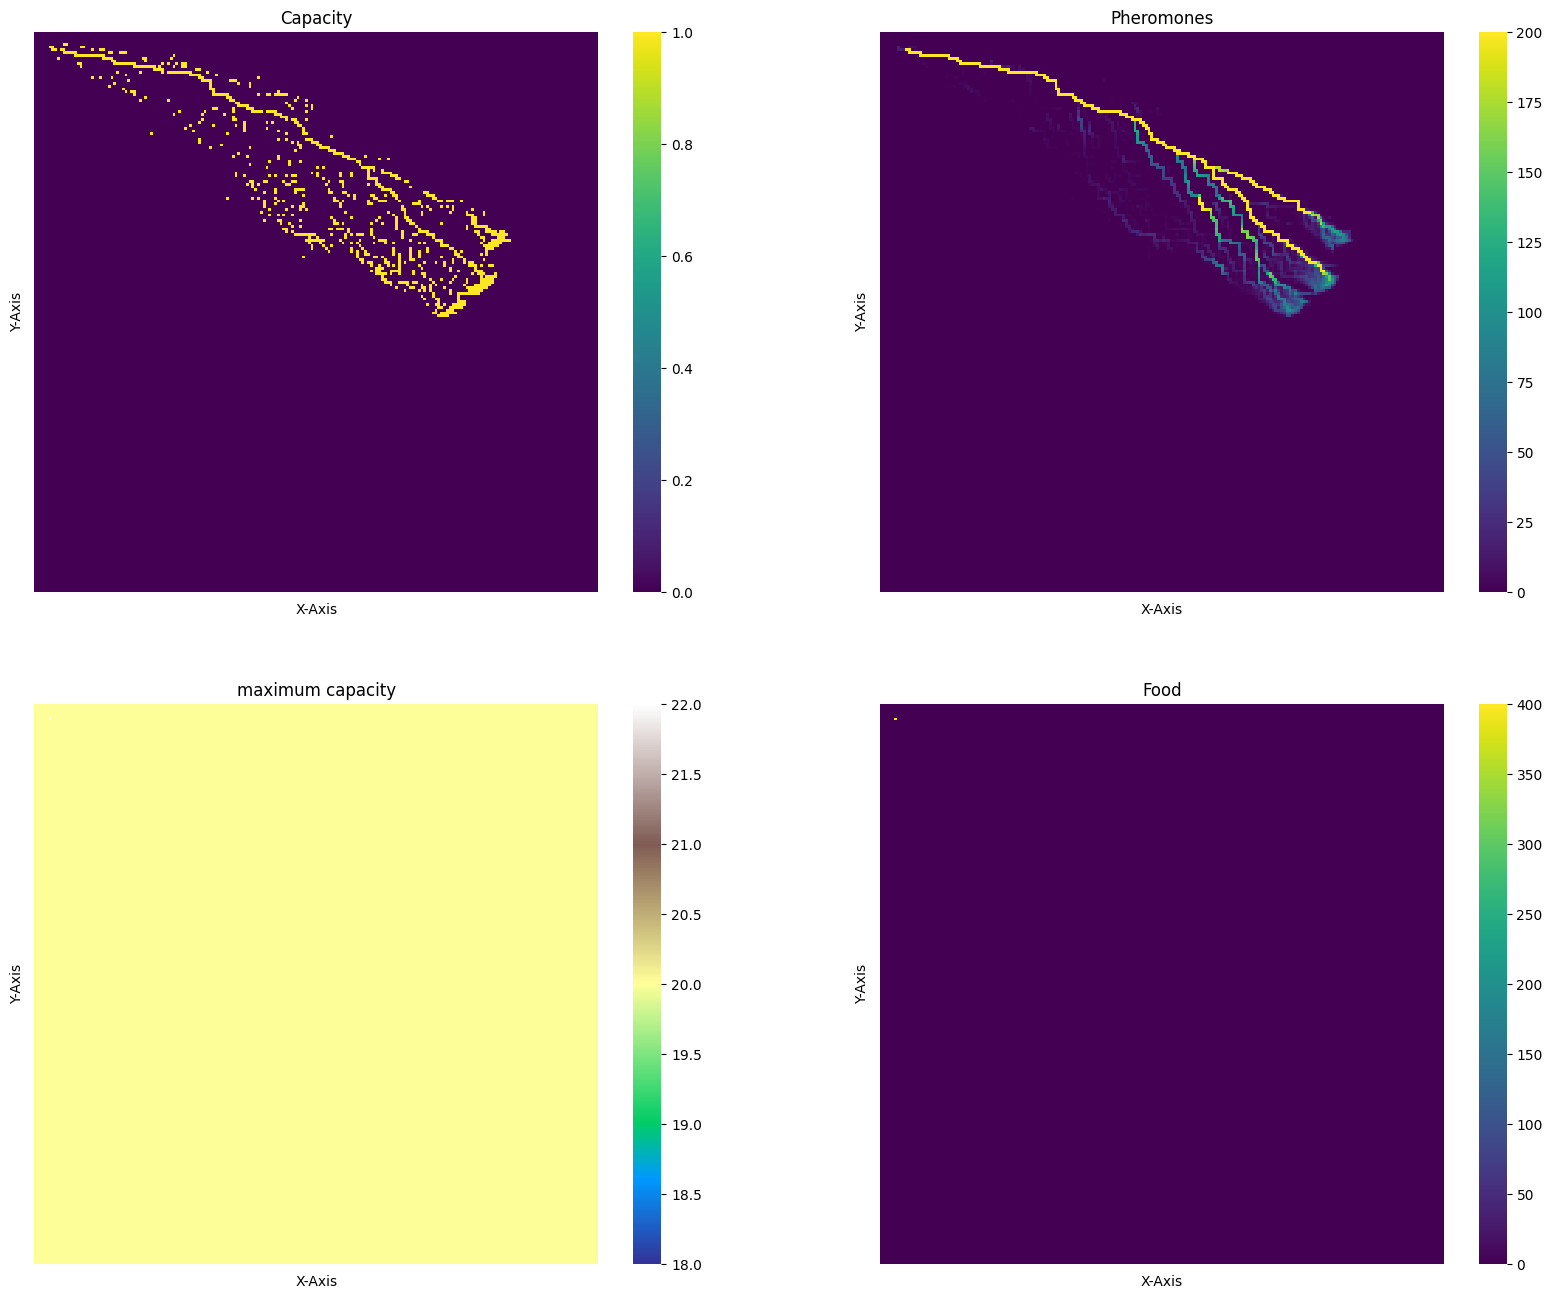

In [82]:
nodes, node_array = create_nodes(n=40000,experiment=2,randomise_capacity = False,terrain=False, one_tree=False,realistic_world=False, evaporation_rate=1/30)
new_nodes = model(nodes=nodes,steps=1000,ants_per_step=10,max_ants=2500)
multiplot(new_nodes,two=False)